# Atmospheres
There is not only magma oceans to MOAI. Atmospheres are one half of the work, and they deserve their own chapter.

## Black body
In the previous chapters, we have already encontered one example atmosphere objects: black body. The atmosphere class is a general class of object, and more specific cases (like the black_body) are implemented in sub-classes. Notice that, although we have only used them in association with magma oceans so far, atmospheres are stand-alone objects that can be defined individually. 

In [1]:
from atmospheres import black_body
from chemistry.molecules import H2O, CO2
atm1 = black_body([H2O,CO2], # let's consider a H2O-CO2 atmosphere
                 [1e5,1e5], # with one bar of each species
                 2500)    # with a surface temperature of 2500 K

On top of its composition and surface temperature, an atmosphere can take a few keyword arguments (we have seen the gravity and planetary radius before, the equilibrium temperature is another one). Here we use the default values, which are Earth-like, for all these.    
You have acces to the partial pressures and the total pressure:

In [2]:
print('p_H2O =',atm1.partial_pressure['H2O'],'Pa')
print('p_CO2 =',atm1.partial_pressure['CO2'],'Pa')
print('p_tot =',atm1.ps,'Pa')

p_H2O = 100000.0 Pa
p_CO2 = 100000.0 Pa
p_tot = 200000.0 Pa


From the pressure, the planetary radius and gravity, you can calculate the atmospheric mass. But you don't even need to remember the formula: there is already a method for that! You can even calculate the mass of each individual species:

In [3]:
print('M_H2O =',atm1.getMass('H2O'),'kg')
print('M_CO2 =',atm1.getMass('CO2'),'kg')
print('M_tot =',atm1.getMass(),'kg')

M_H2O = 3.022723694228641e+18 kg
M_CO2 = 7.388880141447788e+18 kg
M_tot = 1.0411603835676428e+19 kg


Water has a molecular mass of 18, carbon monoxide of 44, and there the same number of moles of each, so what do you think the average molecular mass in the atmosphere will be?

In [4]:
print('average molecular mass =',atm1.average_molecular_mass)

average molecular mass = 31.0


You know what, I think we miss a bit of N$_2$ in our atmosphere, let's add one bar of it:

In [5]:
from chemistry.molecules import N2
atm1.addSpecies(N2,1e5)

# New atmosphere characteristics
print('p_tot =',atm1.ps,'Pa')
print('M_tot =',atm1.getMass(),'kg')
print('average molecular mass =',atm1.average_molecular_mass)

p_tot = 300000.0 Pa
M_tot = 1.5617405753514641e+19 kg
average molecular mass = 29.999999999999996


## Gray atmosphere at radiative equilibrium
That's nice, but if you are interested in the heat flux, black body radiation is surely not a good approximation for a H2O-CO2 atmosphere. So let's look at a more interesting case: the grey atmosphere at radiative equlibrium. Assuming that the atmosphere is at radiative equilibrium, and treating it as a gray gas, allowed Abe and Matsui 1985 to include infrared absorption in a coefficient $\varepsilon$ altering the Stefan law: ${\rm OLR}=\varepsilon\sigma T_{\rm sfc}^4$, where $\sigma$ is the Stefan Blotzmann constant, and $\epsilon$ is related to the optical depth by the formula:    
$$\varepsilon=\frac{2}{2+\Sigma_i\tau_i},$$
where $\tau_i$ is the optical depth of each species in the atmosphere, which is simply its partial pressure times its absorption coefficient: $\tau_i=p_i\times k_{i,0}$.

The gray atmosphere at radiative equilibrium is essentially similar to the black body object, except that it implements this calculation ($\varepsilon$ is referred to as its opacity):

In [6]:
from atmospheres import radiative_grey_atmosphere
atm2 = radiative_grey_atmosphere([H2O,CO2], # let's consider a H2O-CO2 atmosphere
                                 [1e5,1e5], # with one bar of each species
                                 2500)    # with a surface temperature of 2500 K
print('opacity =',atm2.opacity)

opacity = 0.2415331170597951


We can now compare the OLR between the black body (where composition play no role, so the presence of N$_2$ is no problem) and gray atmosphere at radiative equilibrium:

In [7]:
print('black body OLR:', atm1.getOLR(),'W/m²')
print('gray rad-eq OLR:', atm2.getOLR(),'W/m²')

black body OLR: 2214990.007421875 W/m²
gray rad-eq OLR: 534993.4407489041 W/m²


One bar of water and one bar of carbon dioxide have reduced the OLR by a factor of 4: that is clearly not to be neglected!

## Convective atmosphere
### Dry troposphere
As atmospheres grow thick, and become accordingly more optically thick, which allows for strong temperature gradient near their surface (in particular if the surface is hot), which destabilize the atmosphere to convection. The assumption of radiative equilibrium no longer holds; instead, just like the magma ocean, the atmosphere follows an adiabat. The slope of the adiabat is different form that in a magma ocean because the equations of state are different. The slope of the adiabat in the atmosphere (generally called the lapse rate) is given by:    
$$\frac{d\ln{T}}{d\ln{p}}=\frac{R}{c_p},$$
where $R$ is the gas constant (8.314 J/K/mol) and $c_p$ is the molar heat capacity of the atmosphere, which is the sum of each species' heat capacity weighted by its molar fraction. By integrating Eq. 1 from the surface (at $T_{\rm sfc}$), we can calculate the temperture profile in the atmosphere, whcih we the use to calculate the OLR. Notice that this step was implicit in the calculation for the gray atmosphere at radiative equilibrium, and we did not bother getting the temperature profile.     

### Moist troposphere
If the temperature decreases locally below their saturation temperature (or the pressure drops below their saturation pressure, see it as you will), certain gases in the atmosphere (in particular water) can condense. The release of latent heat associated with condensation heats up the atmosphere, thus straightening the adiabat. We then obtain the moist adiabat:    
$$\frac{d\ln{T}}{d\ln{p_a}} = \frac{R}{c_{p,a}}\frac{1+\frac{L_c}{RT}\frac{p_c}{p_a}}{1+\left(\frac{c_{p,c}}{c_{p,a}}+\left(\frac{L_c}{RT}-1\right)\frac{L_c}{c_{p,a}T}\right)\frac{p_c}{p_a}}$$
where we distinguish between the condensible species (subscript $c$) and the non-condensible background gas (subscript $a$, as "air", by analogy with Earth's case). $L_c$ is the condensible latent heat of vaporization (or sublimation) and similar to the dry case, $c_{p,a}$ is the sum of all non-condensible sepcies weighted by their molar fraction in the non condensible gas (i.e. summing to one without counting the condensible gas vapour).    
Notice that this equation gives the lapse rate as a derivative of $p_a$ rather than $p=p_a+p_c$. We can close our system by considering that the condensible gas is always at saturation in the moist troposphere, and make use of the Clausius-Clapeyron relation:

$$p_c=p_{{\rm sat},c}(T)=p_{{\rm ref},c}\exp{\left(\frac{-L_c}{R}\left(\frac{1}{T}-\frac{1}{T_{{\rm ref},c}}\right)\right)}$$
with $p_{{\rm ref},c}$ and $T_{{\rm ref},c}$ a set of reference pressure and temperature for the condensible species, where we know saturation occurs (e.g. the triple point).

MOAI has an atmosphere class which implements both dry and moist troposphere, and self-consistently calculates the saturation level (below which the temperature follows the dry adiabat and above which it follows the moist one). Here is how to call it:

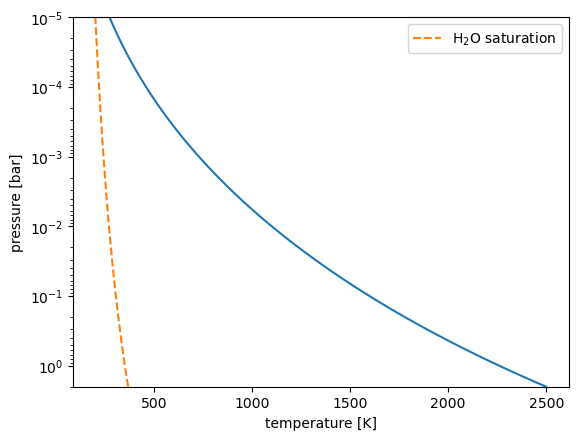

In [8]:
from atmospheres import multi_species_single_condensible_convective_atmosphere
atm3 = multi_species_single_condensible_convective_atmosphere([H2O,CO2], # The condensible species is the first of the list
                                                              [1e5,1e5], # with one bar of each species
                                                               2500)     # with a surface temperature of 2500 K

# plot
import matplotlib.pyplot as plt

# plot lapse rate
plt.semilogy(atm3.profiles['temperature'],atm3.profiles['pressure']*1e-5)

# plot water saturation line
plt.semilogy(H2O.T_dew(atm3.profiles['partial pressure']['H2O']),
             atm3.profiles['pressure']*1e-5,'--',label=r'H$_2$O saturation')

plt.xlabel('temperature [K]')
plt.ylabel('pressure [bar]')
plt.ylim(2,1e-5)
plt.legend()

As can be seen by comparing the solid line with the dashed line, water is never saturated (its partial pressure is always above the saturation pressure at ambient temperature). The whole atmosphere thus follows the dry adiabat. However, magma ocean atmosphere can be much thicker, in which case water saturation is more likely to occur. Let's increase the partial pressure of water and see what happens:

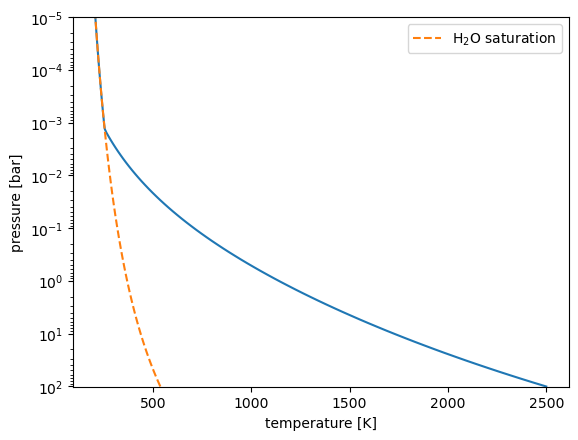

In [9]:
atm3.update(atm3.Ts,   # keep the same surface temperature
            [1e7,1e5]) # increase water's partial pressure to 10 bars

# plot lapse rate
plt.semilogy(atm3.profiles['temperature'],atm3.profiles['pressure']*1e-5)

# plot water saturation line
plt.semilogy(H2O.T_dew(atm3.profiles['partial pressure']['H2O']),
             atm3.profiles['pressure']*1e-5,'--',label=r'H$_2$O saturation')

plt.xlabel('temperature [K]')
plt.ylabel('pressure [bar]')
plt.ylim(102,1e-5)
plt.legend()

The temperature now reaches the saturation temperature slightly above the $p=200$ Pa level (i.e. at lower pressure). The adiabat slope then turns from the dry adiabat to the moist one, which is much steeper (as plotted here). This is due to the fact that adiabatic cooling is partly compensated by latent heat release. It is actually compensated precisely so that the moist adiabat follows water's saturation line.

### Hydrostatic equilibrium
The native vertical coordinate for the atmosphere class is pressure. However, you might be interested in using height instead. Under the assumption of hydrostatic equilibrium, switching is very easy, as you just have to integrate the following equation:
$$\frac{dz}{dp}=-\frac{1}{\rho g}$$
where $z$ is height, $\rho$ is average density (calculated considering the perfect gas equation of state), and $g$ is gravity. By definition of the planetary surface, the boundary condition for this equation is $z(p_{\rm sfc}=0$. To do so, you can activate the hydrostatic equilibrium solver that is built in the multi_species_single_condensible_convective_atmosphere class:

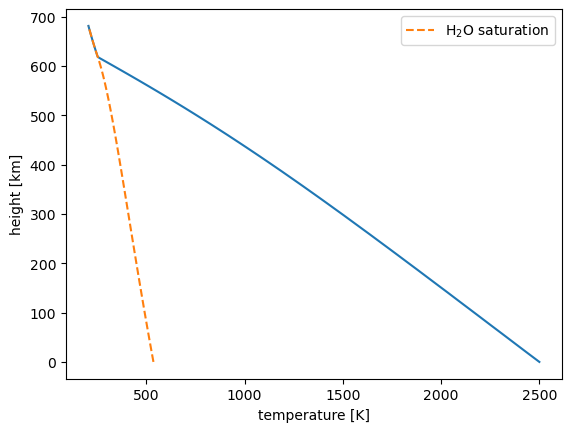

In [10]:
atm3.set_hydrostatic_equilibrium()

plt.plot(atm3.profiles['temperature'],atm3.profiles['height']*1e-3)
plt.plot(H2O.T_dew(atm3.profiles['partial pressure']['H2O']),
             atm3.profiles['height']*1e-3,'--',label=r'H$_2$O saturation')

plt.xlabel('temperature [K]')
plt.ylabel('height [km]')
#plt.ylim(102,1e-5)
plt.legend()

### Convective atmosphere OLR

The multi_species_single_condensible_convective_atmosphere class implements a therodynamic model of the atmosphere. While we have used othe ratmosphere sub-classes to calculate the OLR, this class has no built-in OLR calculator. One could implement a simple grey absorption model along the temperature profile, but it out only be useful as a toy model as it would be very inaccurate. Combining that level of complexity in the thermodynamic model with such simple radiative model makes little sense (except for learning purpose, which is already pretty important). Implementing more complex radiative models (e.g non-gray) is beyond the scope of MOAI. Rather than re-inventing the wheel, we like to rely on other existing codes which do that very well. My personal favourite is petitRADTRANS, because of its Python wraper which makes it very easy to couple with MOAI. Check out the chapter on how to use it!